In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
import shutil
import zipfile
import glob
import os
import time

In [2]:
train_dir = os.path.join(os.getcwd(), 'TB_Chest_Radiography_Database/train')
test_dir = os.path.join(os.getcwd(), 'TB_Chest_Radiography_Database/test')

print(f'the number of train set : {len(os.listdir(train_dir))}')
print(f'the number of test set : {len(os.listdir(test_dir))}')


normal_files = [f'Normal-{i}.png' for i in range(1,3500)]
tuberculosis_files = [f'Tuberculosis-{i}.png' for i in range(1,700)]


the number of train set : 3360
the number of test set : 840


In [3]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, files, root, mode='train', transform=None):
        self.files = files
        self.root = root
        self.mode = mode
        self.transform=transform
        
        if 'Normal' in files[0]:
            self.label = 0

        else:
            self.label = 1
        
    def __len__(self):
        return len(self.files)

        
        
    def __getitem__(self, index):
        img = PIL.Image.open(os.path.join(self.root, self.files[index]))
        if self.transform:
            img = self.transform(img)
        if self.mode == 'train':
            return img, np.array([self.label])
        else:
            return img, self.files[index]


In [8]:
from PIL import Image, ImageOps, ImageFilter

class SmothImage(object):

    def __call__(self,image):
        
        return image.filter(ImageFilter.SMOOTH_MORE)

class ContrastBrightness(object):
    """Image pre-processing.

    alpha = 1.0 # Simple contrast control [1.0-3.0]
    beta = 0    # Simple brightness control [0-100]
    """
    
    def __init__(self, alpha, beta):
        self.alpha = alpha
        self.beta = beta
    
    def __call__(self,image,):
        image = np.array(image)
        for y in range(image.shape[0]):
            for x in range(image.shape[1]):
                image[y,x] = np.clip(self.alpha*image[y,x] + self.beta, 0, 255)

                return Image.fromarray(np.uint8(image)*255)

class HistEqualization(object):
    """Image pre-processing.

    Equalize the image historgram
    """
    
    def __call__(self,image):
        
        return ImageOps.equalize(image, mask = None) 
            
            
            
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.Grayscale(num_output_channels=3),
    torchvision.transforms.RandomRotation(30),
    torchvision.transforms.RandomVerticalFlip(),
    torchvision.transforms.Resize((256,256)),
    torchvision.transforms.RandomCrop(224),
    ContrastBrightness(1.2,25),
    HistEqualization(),
    SmothImage(),
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Normalize([0.4990189, 0.49874797, 0.4984631], [0.21823819, 0.24591278, 0.22876337]),
])
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256,256)),
    torchvision.transforms.RandomCrop(224),
    torchvision.transforms.Grayscale(num_output_channels=3),
    ContrastBrightness(1.2,25),
    HistEqualization(),
    SmothImage(),
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Normalize([0.5066209, 0.50000274, 0.49914467], [0.20135736, 0.22966754, 0.188137]),
])

'''
0.4990189 0.49874797 0.4984631
0.21823819 0.24591278 0.22876337
0.5066209 0.50000274 0.49914467
0.20135736 0.22966754 0.188137

'''


'\n0.4990189 0.49874797 0.4984631\n0.21823819 0.24591278 0.22876337\n0.5066209 0.50000274 0.49914467\n0.20135736 0.22966754 0.188137\n\n'

In [9]:

train_normal_dataset = CustomDataset(normal_files[:2800], train_dir, transform=train_transform)
train_tuberculosis_dataset = CustomDataset(tuberculosis_files[:560], train_dir, transform=train_transform)
test_normal_dataset = CustomDataset(normal_files[2800:], test_dir, transform=test_transform)
test_tuberculosis_dataset = CustomDataset(tuberculosis_files[560:], test_dir, transform=test_transform)

train_dataset = torch.utils.data.ConcatDataset([train_normal_dataset, train_tuberculosis_dataset])
test_dataset = torch.utils.data.ConcatDataset([test_normal_dataset, test_tuberculosis_dataset])



In [10]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

train_norm_loader = torch.utils.data.DataLoader(train_dataset, batch_size=3360, shuffle=True)
test_norm_loader = torch.utils.data.DataLoader(test_dataset, batch_size=840, shuffle=True)


'''
#samples, labels = iter(train_norm_loader).next()    ##mean: 0.5291, std: 0.2344

meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x,_ in train_norm_loader]
stdRGB = [np.std(x.numpy(), axis=(1,2)) for x,_ in train_norm_loader]

meanR = np.mean([m[0] for m in meanRGB])
meanG = np.mean([m[1] for m in meanRGB])
meanB = np.mean([m[2] for m in meanRGB])

stdR = np.mean([s[0] for s in stdRGB])
stdG = np.mean([s[1] for s in stdRGB])
stdB = np.mean([s[2] for s in stdRGB])

print(meanR, meanG, meanB)
print(stdR, stdG, stdB)

meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x,_ in test_norm_loader]
stdRGB = [np.std(x.numpy(), axis=(1,2)) for x,_ in test_norm_loader]

meanR = np.mean([m[0] for m in meanRGB])
meanG = np.mean([m[1] for m in meanRGB])
meanB = np.mean([m[2] for m in meanRGB])

stdR = np.mean([s[0] for s in stdRGB])
stdG = np.mean([s[1] for s in stdRGB])
stdB = np.mean([s[2] for s in stdRGB])
print(meanR, meanG, meanB)
print(stdR, stdG, stdB)
'''




'\n#samples, labels = iter(train_norm_loader).next()    ##mean: 0.5291, std: 0.2344\n\nmeanRGB = [np.mean(x.numpy(), axis=(1,2)) for x,_ in train_norm_loader]\nstdRGB = [np.std(x.numpy(), axis=(1,2)) for x,_ in train_norm_loader]\n\nmeanR = np.mean([m[0] for m in meanRGB])\nmeanG = np.mean([m[1] for m in meanRGB])\nmeanB = np.mean([m[2] for m in meanRGB])\n\nstdR = np.mean([s[0] for s in stdRGB])\nstdG = np.mean([s[1] for s in stdRGB])\nstdB = np.mean([s[2] for s in stdRGB])\n\nprint(meanR, meanG, meanB)\nprint(stdR, stdG, stdB)\n\nmeanRGB = [np.mean(x.numpy(), axis=(1,2)) for x,_ in test_norm_loader]\nstdRGB = [np.std(x.numpy(), axis=(1,2)) for x,_ in test_norm_loader]\n\nmeanR = np.mean([m[0] for m in meanRGB])\nmeanG = np.mean([m[1] for m in meanRGB])\nmeanB = np.mean([m[2] for m in meanRGB])\n\nstdR = np.mean([s[0] for s in stdRGB])\nstdG = np.mean([s[1] for s in stdRGB])\nstdB = np.mean([s[2] for s in stdRGB])\nprint(meanR, meanG, meanB)\nprint(stdR, stdG, stdB)\n'

torch.Size([3, 224, 224])
torch.Size([1])


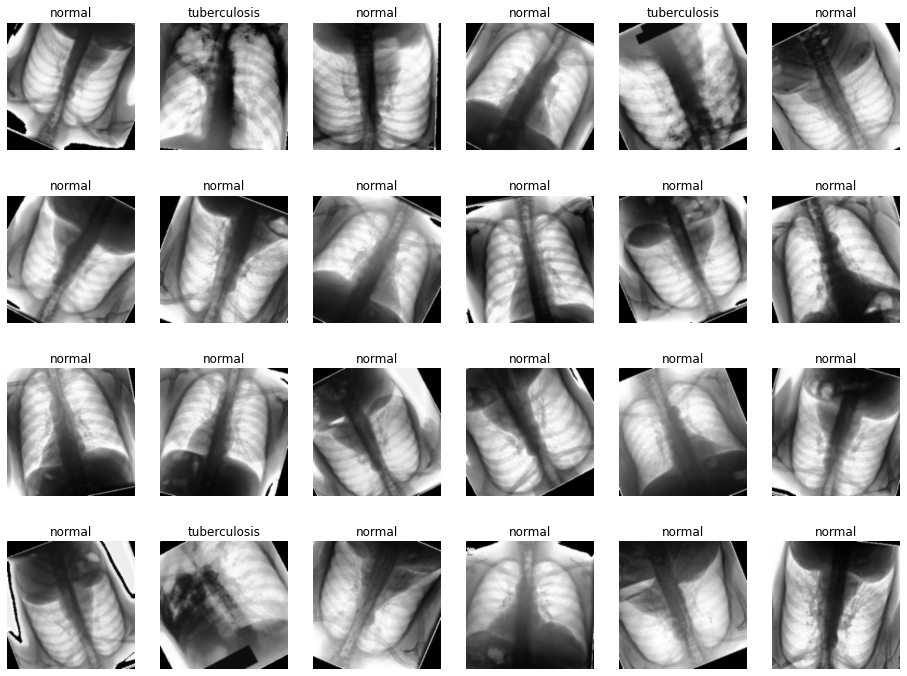

In [11]:
samples, labels = iter(train_loader).next()
classes = {0:'normal', 1:'tuberculosis'}
fig = plt.figure(figsize=(16,24))


for i in range(24):
    a = fig.add_subplot(4,6,i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
    
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)
print(samples[i].shape)
print(labels[i].shape)



In [12]:
device='cuda' if torch.cuda.is_available() else 'cpu'
print(device)


cuda


In [13]:
import torch
from torch import nn

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)############
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)


In [14]:
batch_size = 16
num_classes = 2

model = ViT(
    image_size = 224,
    patch_size = 56,
    num_classes = 2,
    dim = 256,
    depth = 4,
    heads = 6,
    mlp_dim = 1024,
    dropout = 0.1,
    channels = 3,
    emb_dropout = 0.1
).to(device)



In [15]:
!pip install torchsummary
from torchsummary import summary




model.cuda()
summary(model, input_size=(3,224,224))


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Rearrange-1             [-1, 16, 9408]               0
            Linear-2              [-1, 16, 256]       2,408,704
           Dropout-3              [-1, 17, 256]               0
         LayerNorm-4              [-1, 17, 256]             512
            Linear-5             [-1, 17, 1152]         294,912
           Softmax-6            [-1, 6, 17, 17]               0
            Linear-7              [-1, 17, 256]          98,560
           Dropout-8              [-1, 17, 256]               0
         Attention-9              [-1, 17, 256]               0
          PreNorm-10              [-1, 17, 256]               0
        LayerNorm-11              [-1, 17, 256]             512
           Linear-12             [-1, 17, 1024]         263,168
             GELU-13          

In [16]:
def fit(model, criterion, optimizer, epochs, train_loader, valid_loader):
    model.train()
    train_loss = 0
    train_acc = 0
    train_correct = 0
    
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []
    
    for epoch in range(epochs):
        start = time.time()
        
        for train_x, train_y in train_loader:
            model.train()
            #train_y = train_y.type(torch.LongTensor)
            train_y = train_y.squeeze(1)
            train_x, train_y = train_x.to(device), train_y.to(device).long()
            optimizer.zero_grad()
            pred = model(train_x)
            _, preds = torch.max(pred, 1)
            #print(pred.shape)
            #print(train_y.shape)
            #print(pred.shape)
            loss = criterion(pred, train_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            #running_corrects += torch.sum(preds == labels.data)
            train_correct += torch.sum(preds.cpu() == train_y.data.cpu())
            
            #y_pred = pred.cpu()
            #print(y_pred)
            #y_pred[y_pred >= 0.5] = 1
            #y_pred[y_pred < 0.5] = 0
           
            
        # validation data check
        valid_loss = 0
        valid_acc = 0
        valid_correct = 0
        for valid_x, valid_y in valid_loader:
            with torch.no_grad():
                model.eval()
                #valid_y = valid_y.type(torch.LongTensor)
                valid_y = valid_y.squeeze(1)
                valid_x, valid_y = valid_x.to(device), valid_y.to(device).long()
                pred = model(valid_x)
                _, preds_val = torch.max(pred, 1)
                loss = criterion(pred, valid_y)
            valid_loss += loss.item()
            
            #running_corrects += torch.sum(preds == labels.data)
            valid_correct += torch.sum(preds_val.cpu() == valid_y.data.cpu())
            
            #y_pred = pred.cpu()
            #y_pred[y_pred >= 0.5] = 1
            #y_pred[y_pred < 0.5] = 0
            #valid_correct += y_pred.eq(valid_y.cpu()).int().sum()
            
        train_acc = train_correct/len(train_loader.dataset)
        valid_acc = valid_correct/len(valid_loader.dataset)
        print(f'{time.time() - start:.3f}sec : [Epoch {epoch+1}/{epochs}] -> train loss: {train_loss/len(train_loader):.4f}, train acc: {train_acc*100:.3f}% / valid loss: {valid_loss/len(valid_loader):.4f}, valid acc: {valid_acc*100:.3f}%')
        train_losses.append(train_loss/len(train_loader))
        train_accuracies.append(train_acc)
        valid_losses.append(valid_loss/len(valid_loader))
        valid_accuracies.append(valid_acc)
        
        train_loss = 0
        train_acc = 0
        train_correct = 0
    plt.plot(train_losses, label='loss')
    plt.plot(train_accuracies, label='accuracy')
    plt.legend()
    plt.title('train loss and accuracy')
    plt.show()
    plt.plot(valid_losses, label='loss')
    plt.plot(valid_accuracies, label='accuracy')
    plt.legend()
    plt.title('valid loss and accuracy')
    plt.show()



34.621sec : [Epoch 1/30] -> train loss: 0.2969, train acc: 86.696% / valid loss: 0.2908, valid acc: 88.186%
34.961sec : [Epoch 2/30] -> train loss: 0.2914, train acc: 87.827% / valid loss: 0.2847, valid acc: 87.351%
34.913sec : [Epoch 3/30] -> train loss: 0.2801, train acc: 88.185% / valid loss: 0.2846, valid acc: 87.947%
34.870sec : [Epoch 4/30] -> train loss: 0.2839, train acc: 87.887% / valid loss: 0.2834, valid acc: 87.589%
34.675sec : [Epoch 5/30] -> train loss: 0.2775, train acc: 87.619% / valid loss: 0.2895, valid acc: 88.663%
34.912sec : [Epoch 6/30] -> train loss: 0.2821, train acc: 88.601% / valid loss: 0.2852, valid acc: 88.783%
35.229sec : [Epoch 7/30] -> train loss: 0.2837, train acc: 88.006% / valid loss: 0.2695, valid acc: 88.663%
35.058sec : [Epoch 8/30] -> train loss: 0.2894, train acc: 88.214% / valid loss: 0.2744, valid acc: 89.260%
35.193sec : [Epoch 9/30] -> train loss: 0.2845, train acc: 88.214% / valid loss: 0.2922, valid acc: 88.305%
35.129sec : [Epoch 10/30] ->

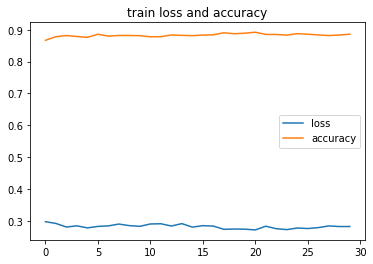

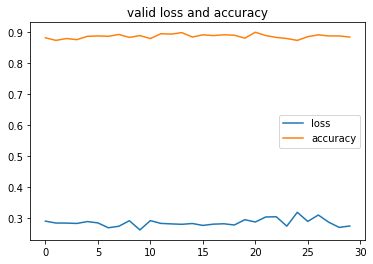

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)

fit(model, criterion, optimizer, 30, train_loader, test_loader)

